# Import dependencies

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,classification_report

In [118]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,StandardScaler,LabelEncoder
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
# import lightgbm as lgb
from imblearn.over_sampling import SMOTE
import xgboost as xgb

# Load Data

In [4]:
fraud_df = pd.read_csv("data/fraud_mock.csv")

In [6]:
fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column            Dtype  
---  ------            -----  
 0   time_ind          int64  
 1   transac_type      object 
 2   amount            float64
 3   src_acc           object 
 4   src_bal           float64
 5   src_new_bal       float64
 6   dst_acc           object 
 7   dst_bal           float64
 8   dst_new_bal       float64
 9   is_fraud          int64  
 10  is_flagged_fraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


# Q1: EDA

check Nan 

In [7]:
fraud_df.isna().sum()

time_ind            0
transac_type        0
amount              0
src_acc             0
src_bal             0
src_new_bal         0
dst_acc             0
dst_bal             0
dst_new_bal         0
is_fraud            0
is_flagged_fraud    0
dtype: int64

no missing data

normally, most of the transaction data is legit while only a few of them are fraud

In [8]:
fraud_df["is_fraud"].value_counts()

is_fraud
0    6354407
1       8213
Name: count, dtype: int64

<Axes: xlabel='is_fraud', ylabel='count'>

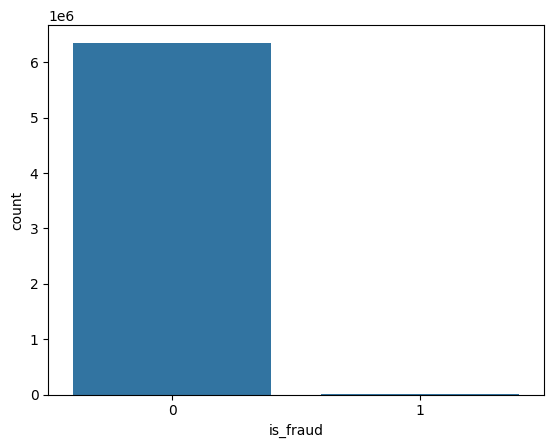

In [9]:
sns.countplot(x='is_fraud', data=fraud_df)

there are <br>
- 6354407 normal transactions
- 8213 fraud transactions

check mean of amount of normal transaction and fraud transaction

In [10]:
fraud_df.groupby("is_fraud")[["amount"]].mean()

,amount
is_fraud,
0,1.781970e+05
1,1.467967e+06


check relation between is_flagged_fraud and is_fraud

In [11]:
# correlation
fraud_df[["is_flagged_fraud","is_fraud"]].corr()

,is_flagged_fraud,is_fraud
is_flagged_fraud,1.000000,0.044109
is_fraud,0.044109,1.000000


In [12]:
cm = confusion_matrix(fraud_df["is_fraud"], fraud_df["is_flagged_fraud"])

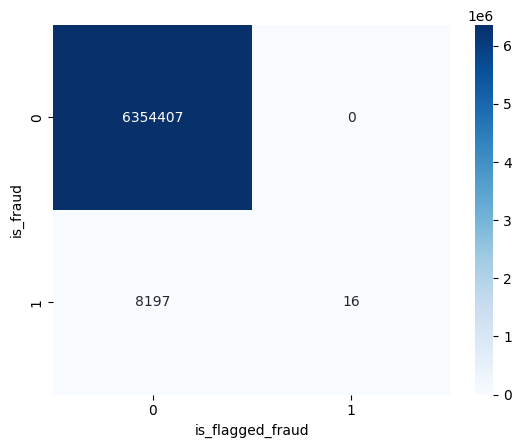

In [13]:
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('is_flagged_fraud')
plt.ylabel('is_fraud')
plt.show()

we found that current flagging rule produce significant false negative


check correlation between amount, source balance, new source balance

In [14]:
fraud_df[["amount","src_bal","src_new_bal"]].corr()

,amount,src_bal,src_new_bal
amount,1.000000,-0.002762,-0.007861
src_bal,-0.002762,1.000000,0.998803
src_new_bal,-0.007861,0.998803,1.000000


src_bal and src_new_bal have high correlation with each other, it may not be suitable to use both of them simultaneously as a feature.

In [15]:
fraud_df[["amount","dst_bal","dst_new_bal"]].corr()

,amount,dst_bal,dst_new_bal
amount,1.000000,0.294137,0.459304
dst_bal,0.294137,1.000000,0.976569
dst_new_bal,0.459304,0.976569,1.000000


the pattern also apply to dst_bal and dst_new_bal

check number of fraud in each type of transaction

In [16]:
transaction_type_fruad_count = fraud_df.groupby(["is_fraud","transac_type"]).size().reset_index(name='count')
transaction_type_fruad_count

,is_fraud,transac_type,count
0,0,CASH_IN,1399284
1,0,CASH_OUT,2233384
2,0,DEBIT,41432
3,0,PAYMENT,2151495
4,0,TRANSFER,528812
5,1,CASH_OUT,4116
6,1,TRANSFER,4097


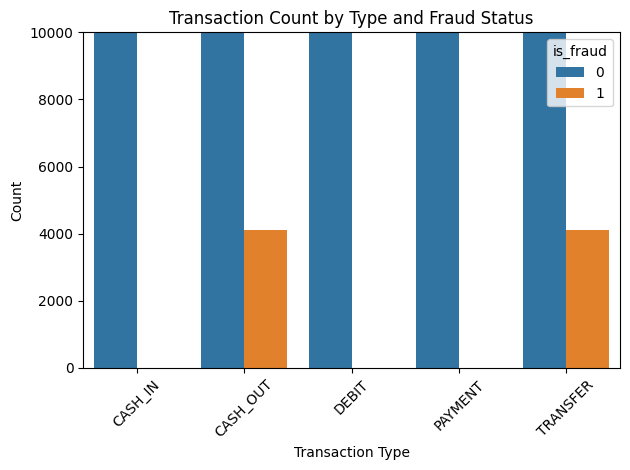

In [17]:
sns.barplot(data=transaction_type_fruad_count, x='transac_type', y='count', hue='is_fraud')
plt.title('Transaction Count by Type and Fraud Status')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.ylim(0,10000)
plt.tight_layout()
plt.show()

we only found fraud in CASH_OUT and TRANSFER

In [18]:
fraud_df["src_acc"].value_counts()

src_acc
acc8073602    3
acc5373698    3
acc6699137    3
acc2805971    3
acc6915245    3
             ..
acc6166648    1
acc8256001    1
acc2409371    1
acc6515799    1
acc5436580    1
Name: count, Length: 6353307, dtype: int64

# Q2: training

## Feature selection

In [19]:
fraud_df.columns

Index(['time_ind', 'transac_type', 'amount', 'src_acc', 'src_bal',
       'src_new_bal', 'dst_acc', 'dst_bal', 'dst_new_bal', 'is_fraud',
       'is_flagged_fraud'],
      dtype='object')

In [129]:
numerical_features = ['amount','src_bal','dst_bal']
categorical_features = ['transac_type']

In [130]:
X = fraud_df[numerical_features + categorical_features]
y = fraud_df["is_fraud"]

## Train Test Split

In [131]:
X_train,X_test, y_train, y_test = train_test_split(X,y,test_size= 0.25,random_state=42,stratify=y)

## Data preprocessing

In [133]:
preprocessor = ColumnTransformer(
    [
        ("cat",OneHotEncoder(sparse_output=False,drop="first"),categorical_features),
        ("num",StandardScaler(),numerical_features)
    ]
)
smt = SMOTE(random_state=42)

In [161]:
pipeline = Pipeline(steps=[("preprocessor",preprocessor),
                            ("smt",smt),
                            ('xgb', xgb.XGBClassifier(random_state=42))
])

# Train

In [167]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['transac_type']),
                                                 ('num', StandardScaler(),
                                                  ['amount', 'src_bal',
                                                   'dst_bal'])])),
                ('smt', SMOTE(random_state=42)),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_byt...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [170]:
y_prob = pipeline.predict_proba(X_test)[:, 1]

In [171]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

In [172]:
auc_score

np.float64(0.999262283353975)

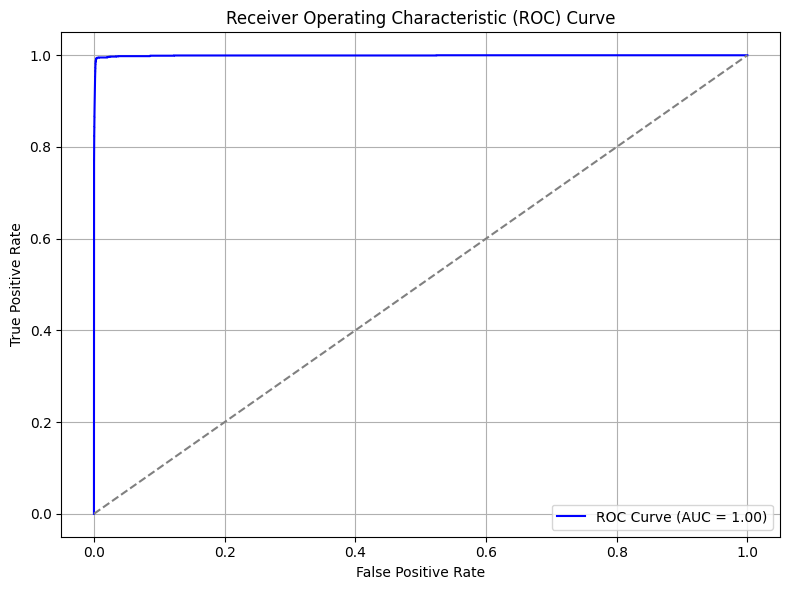

In [173]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [174]:
import numpy as np

j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]
y_pred = (y_prob >= optimal_threshold).astype(int)
report = classification_report(y_test,y_pred)

In [175]:
optimal_threshold

np.float32(0.4004254)

In [176]:
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588602
           1       0.21      0.99      0.35      2053

    accuracy                           1.00   1590655
   macro avg       0.61      0.99      0.67   1590655
weighted avg       1.00      1.00      1.00   1590655



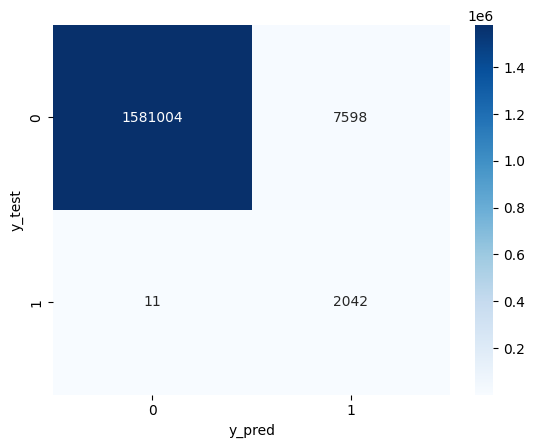

In [177]:
pred_confusion_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(pred_confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()

In [ ]:
import joblib
joblib.dump(pipeline, '../model/xgb_pipeline.pkl')

['xgb_pipeline_with_smote.pkl']